In [42]:
!mkdir -p models
!mkdir -p .keras_processed_images

# Download the NYU DenseDepth model
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O models/nyu.h5 -q

# Download our models
!wget https://github.com/RohitAwate/Bokehlicious/raw/main/models/depth_model.pth -O models/depth_model.pth -q
!wget https://github.com/RohitAwate/Bokehlicious/raw/main/models/portrait_model.pth -O models/portrait_model.pth -q

In [43]:
from PIL import Image
import os
import skimage
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.layers import Layer
import keras.utils.conv_utils as conv_utils
import keras.backend as K
import tensorflow as tf
import glob
from keras.models import load_model
from keras.layers import InputSpec
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch
import cv2
import numpy as np
import torchvision.transforms.functional as TF

In [44]:
# Adapted from: https://github.com/ialhashim/DenseDepth/blob/master/layers.py

def data_format_normalized(format):
    """
    Checks if the image data is in the specified format.
    Accepted formats are: channels_first or channels_last.
    """
    if format is None:
        format = K.image_data_format()
    data_format = format.lower()
    if data_format not in ('channels_first', 'channels_last'):
        raise ValueError(f'Image data format must be either channel-first or channel-last. Recevied {str(format)}')
    return data_format


class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = data_format_normalized(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape based on the data format specified.
        Channels_last: (N, H, W, C)
        Channels_first: (N, C, H, W)
        """
        # Calculate (N, H, W, C)
        if self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0], height, width, input_shape[3])
        # Calculate (N, C, H, W)
        elif self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0], input_shape[1], height, width)
            
    def call(self, inputs):
        """
        Returns the resized image based on the data format specified.
        Uses Bilinear Interpolation for resizing.
        """
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        elif self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None

        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        """
        Returns the configuration for the model.
        """
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [45]:
# Adapted from: https://github.com/ialhashim/DenseDepth/blob/master/utils.py


def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Stack the image thrice if the number of channels is 1
    if len(images.shape) < 3: images = np.stack((images, images, images), axis=2)
    
    # Reshape the image (1, C, H, W)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    
    # Get the predictions
    predictions = model.predict(images, batch_size=batch_size)
    return np.clip(maxDepth/predictions, minDepth, maxDepth) / maxDepth


def load_images(image_files):
    """
    Functionality to multiple iamges from a directory.
    """
    images = []
    for image_file in image_files:
        # Open the image and clip it
        x = np.clip(np.asarray(Image.open(image_file), dtype=float) / 255, 0, 1)
        # Append the images to list
        images.append(x)
    return np.stack(images, axis=0)


def to_multichannel(image):
    """
    Convert 2D image to 3D image by stacking
    """
    # Return the image if in correct shape
    if image.shape[2] == 3: return image
    # Get the image
    image = image[:, :, 0]
    # Return the stacked image
    return np.stack((image, image, image), axis=2)


def display_images(outputs, inputs=None):
    """
    Get the plasma map for the depth map
    """
    # Get the cmap from matplotlib
    plasma = plt.get_cmap('plasma')
    
    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)

    images = []

    for i in range(outputs.shape[0]):
        imgs = []
        # Rescale the image (Min max normalization)
        rescaled = outputs[i][:, :, 0]
        rescaled = rescaled - np.min(rescaled)
        rescaled = rescaled / np.max(rescaled)

        imgs.append(plasma(rescaled)[:, :, :3])
        img_set = np.hstack(imgs)
        images.append(img_set)

    images = np.stack(images)

    return skimage.util.montage(images, multichannel=True, fill=(0, 0, 0))

In [46]:
# Load the DenseDepth model
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
depth_model_pre = load_model('models/nyu.h5', custom_objects=custom_objects, compile=False)

In [47]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import ImageFilter

In [48]:
class PortUNet(nn.Module):
  def __init__(self):
    super(PortUNet, self).__init__()

    # Define the encoder layers
    self.dense_net = models.densenet121(pretrained=True)
    self.freeze_pretrained_model(False)

    # Define the decoder layers
    self.dec1 = nn.Conv2d(1024+1024, 512, 3, padding=1)
    self.d_bn1 = nn.BatchNorm2d(512)

    self.dec2 = nn.Conv2d(512+512, 256, 5, padding=1)
    self.d_bn2 = nn.BatchNorm2d(256)
    
    self.dec3 = nn.Conv2d(256+256, 128, 5, padding=1)
    self.d_bn3 = nn.BatchNorm2d(128)
    
    self.dec4 = nn.Conv2d(64+128, 16, 7, padding=1)
    self.d_bn4 = nn.BatchNorm2d(16)

    self.dec5 = nn.Conv2d(16+4, 1, 9, padding=4)

  def forward(self, images):
    # Encode the input image
    features = [images[:, 0:3, :, :]]
    for _, layer in self.dense_net.features._modules.items():
        features.append(layer(features[-1]))

    enc6 = features[11]
    enc5 = features[9]
    enc4 = features[7]
    enc3 = features[5]
    enc2 = features[3]
    enc1 = features[0]

    _, _, H, W = enc5.shape
    up1 = nn.functional.interpolate(enc6, size=(H, W), mode='bilinear')
    dec1 = F.relu(self.d_bn1(self.dec1(torch.cat((up1, enc5), dim=1))))

    _, _, H, W = enc4.shape
    up2 = nn.functional.interpolate(dec1, size=(H, W), mode='bilinear')
    dec2 = F.relu(self.d_bn2(self.dec2(torch.cat((up2, enc4), dim=1))))

    _, _, H, W = enc3.shape
    up3 = nn.functional.interpolate(dec2, size=(H, W), mode='bilinear')
    dec3 = F.relu(self.d_bn3(self.dec3(torch.cat((up3, enc3), dim=1))))

    _, _, H, W = enc2.shape
    up4 = nn.functional.interpolate(dec3, size=(H, W), mode='bilinear')
    dec4 = F.relu(self.dec4(torch.cat((up4, enc2), dim=1)))

    _, _, H, W = enc1.shape
    up5 = nn.functional.interpolate(dec4, size=(H, W), mode='bilinear')
    dec5 = torch.sigmoid(self.dec5(torch.cat((images, up5), dim=1)))

    # Return the final decoded image
    # return nn.functional.interpolate(dec5, size=(H, W), mode='bilinear')
    return dec5

  def freeze_pretrained_model(self, freeze: bool):
    for param in self.dense_net.features.parameters():
      param.requires_grad = not freeze

In [49]:
class DepthUNet(nn.Module):
  def __init__(self):
    super(DepthUNet, self).__init__()

    # Define the encoder layers
    self.dense_net = models.densenet121(pretrained=True)
    self.freeze_pretrained_model(False)

    # Define the decoder layers
    self.dec1 = nn.Conv2d(1024+1024, 512, 3, padding=1)
    self.d_bn1 = nn.BatchNorm2d(512)

    self.dec2 = nn.Conv2d(512+512, 256, 5, padding=1)
    self.d_bn2 = nn.BatchNorm2d(256)
    
    self.dec3 = nn.Conv2d(256+256, 128, 5, padding=1)
    self.d_bn3 = nn.BatchNorm2d(128)
    
    self.dec4 = nn.Conv2d(64+128, 16, 7, padding=1)
    self.d_bn4 = nn.BatchNorm2d(16)

    self.dec5 = nn.Conv2d(16+3, 1, 9, padding=1)

  def forward(self, images):
    # Encode the input image
    features = [images[:, 0:3, :, :]]
    for _, layer in self.dense_net.features._modules.items():
        features.append(layer(features[-1]))

    enc6 = features[11]
    enc5 = features[9]
    enc4 = features[7]
    enc3 = features[5]
    enc2 = features[3]
    enc1 = features[0]

    # Decode the input image
    _, _, H, W = enc5.shape
    up1 = nn.functional.interpolate(enc6, size=(H, W), mode='bilinear')
    dec1 = F.relu(self.d_bn1(self.dec1(torch.cat((up1, enc5), dim=1))))

    _, _, H, W = enc4.shape
    up2 = nn.functional.interpolate(dec1, size=(H, W), mode='bilinear')
    dec2 = F.relu(self.d_bn2(self.dec2(torch.cat((up2, enc4), dim=1))))

    _, _, H, W = enc3.shape
    up3 = nn.functional.interpolate(dec2, size=(H, W), mode='bilinear')
    dec3 = F.relu(self.d_bn3(self.dec3(torch.cat((up3, enc3), dim=1))))

    _, _, H, W = enc2.shape
    up4 = nn.functional.interpolate(dec3, size=(H, W), mode='bilinear')
    dec4 = F.relu(self.dec4(torch.cat((up4, enc2), dim=1)))

    _, _, H, W = enc1.shape
    up5 = nn.functional.interpolate(dec4, size=(H, W), mode='bilinear')
    dec5 = torch.sigmoid(self.dec5(torch.cat((images[:, 0:3, :, :], up5), dim=1)))

    # Return the final decoded image
    return nn.functional.interpolate(dec5, size=(H, W), mode='bilinear')

  def freeze_pretrained_model(self, freeze: bool):
    for param in self.dense_net.features.parameters():
      param.requires_grad = not freeze

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
portrait_model = PortUNet()
portrait_model.load_state_dict(torch.load("models/portrait_model.pth", map_location=device))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [52]:
depth_model = DepthUNet()
depth_model.load_state_dict(torch.load("models/depth_model.pth", map_location=device))

<All keys matched successfully>

In [53]:
portrait_model = portrait_model.to(device)
depth_model = depth_model.to(device)

In [54]:
def generate_edge_mask(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edge = cv2.Sobel(gray, cv2.CV_8U, 1, 1, ksize=5)
    return edge

In [58]:
def get_bokeh(image_path: str, blur_intensity: int = 15):
    if blur_intensity % 2 == 0:
        blur_intensity -= 1

    # Default size of the image
    size = (320, 416)

    # Load the image
    input_image = Image.open(image_path)
    input_image = input_image.resize(size)

    png_file_path = '.keras_processed_images/img_for_keras.png'
    save_image = Image.open(image_path)
    save_image = save_image.resize(size)
    save_image.save(png_file_path)
    input_image_for_depth = load_images(glob.glob(png_file_path))

    # Generate edge mask
    edges = generate_edge_mask(input_image)

    input_image = np.array(input_image)

    input_image = TF.to_tensor(input_image)
    edges = TF.to_tensor(edges)[0]

    # Add edge output
    input_image = torch.cat((input_image, edges.unsqueeze(dim=0)), dim=0).unsqueeze(0)

    # Get depth map using DenseDepth
    depth_mask_dd = predict(depth_model_pre, input_image_for_depth)

    # Convert the image to original size by interpolation
    _, H, W, _ = depth_mask_dd.shape
    depth_mask_dd = F.interpolate(torch.Tensor(depth_mask_dd).permute(0, 3, 1, 2), (H * 2, W * 2), mode='bilinear')
    depth_mask_dd = depth_mask_dd.permute(0, 2, 3, 1)

    # portrait_model.eval()
    portrait_mask = portrait_model(input_image)
    with torch.no_grad():
        
        # Perform edge processing
        portrait_mask = portrait_mask[0]
        portrait_mask = (portrait_mask - portrait_mask.mean()) / portrait_mask.std()
        portrait_mask = np.where(portrait_mask.cpu().numpy() > 0, 1, 0)
        EDGE_WIDTH = 3
        output_pil = Image.fromarray(np.uint8(portrait_mask.squeeze(0))).convert('RGB')
        border_mask = output_pil.filter(ImageFilter.MaxFilter(size=EDGE_WIDTH))
        
        border_mask = np.array(border_mask).transpose(2, 0, 1) - portrait_mask.squeeze()
        fine_mask = np.logical_or(np.logical_and(border_mask[0], edges), portrait_mask.squeeze(0))
        fine_mask = cv2.GaussianBlur(fine_mask.cpu().numpy(), (EDGE_WIDTH, EDGE_WIDTH), cv2.BORDER_DEFAULT)

        # Get depth of the image
        depth_mask_our = depth_model(input_image)

        # Apply depthwise gaussian blur to the images
        gaussian_stacks = []
        for sigma in range(1, 20, 4):
            gaussian_stacks.append(cv2.GaussianBlur(input_image[0, :3, :, :].cpu().numpy().transpose(1, 2, 0), (blur_intensity * sigma, blur_intensity * sigma), 5))

        depth_mask_dd = np.repeat(depth_mask_dd, 3).reshape(gaussian_stacks[0].shape)
        depth_mask_dd = (depth_mask_dd - depth_mask_dd.min()) / (depth_mask_dd.max() - depth_mask_dd.min())
        
        count = 0
        recreated_image = input_image[0, :3, :, :].numpy().transpose(1, 2, 0)
        for depth in [0, 0.2, 0.4, 0.6, 0.8]:
            recreated_image = np.where(np.logical_and(depth <= depth_mask_dd, depth_mask_dd <= depth + 0.2), 
                                        gaussian_stacks[count],
                                        recreated_image)
            count += 1

        
        fine_mask = fine_mask.repeat(3).reshape(recreated_image.shape)
        bokehlicious_image = np.where(fine_mask, input_image[0][:3, :, :].permute(1, 2, 0), recreated_image)

    with torch.no_grad():
        plt.figure(figsize=(25, 25))
        plt.subplot(1, 5, 1)
        plt.imshow(input_image[0, :3, :, :].permute(1, 2, 0))
        plt.title('Original Image')

        plt.subplot(1, 5, 2)
        plt.title('Dense depth map')
        plt.imshow(np.where(depth_mask_dd, depth_mask_dd, 0)[:, :, 0], cmap=plt.get_cmap('plasma'))

        plt.subplot(1, 5, 3)
        plt.imshow(fine_mask[:, :, 0])
        plt.title('Portrait Mask')

        # plt.figure(figsize=(20, 20))
        plt.subplot(1, 5, 4)
        plt.imshow(recreated_image)
        plt.title('Depthwise blur')

        plt.subplot(1, 5, 5)
        plt.title('Bokehlicious image')
        plt.imshow(bokehlicious_image)

        plt.show()

1/1 [==============================] - 2s 2s/step


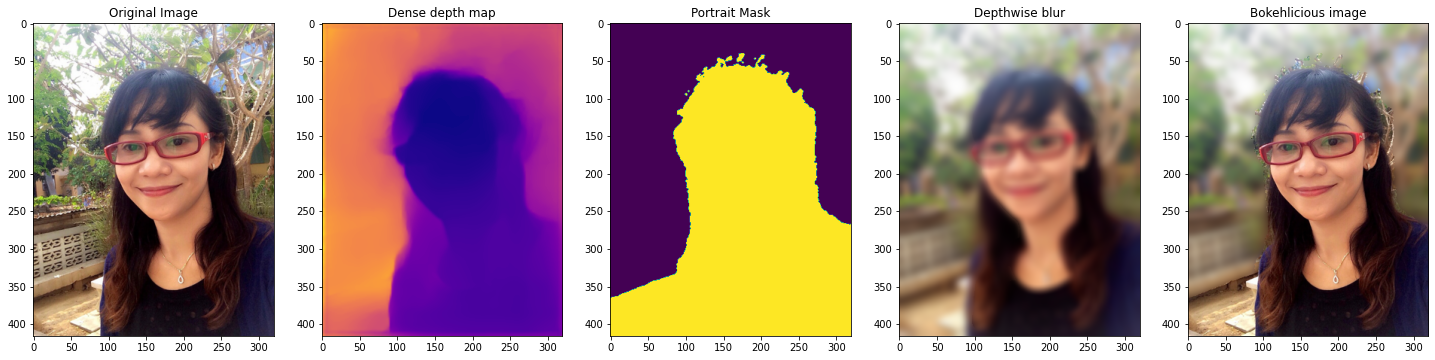

1/1 [==============================] - 2s 2s/step


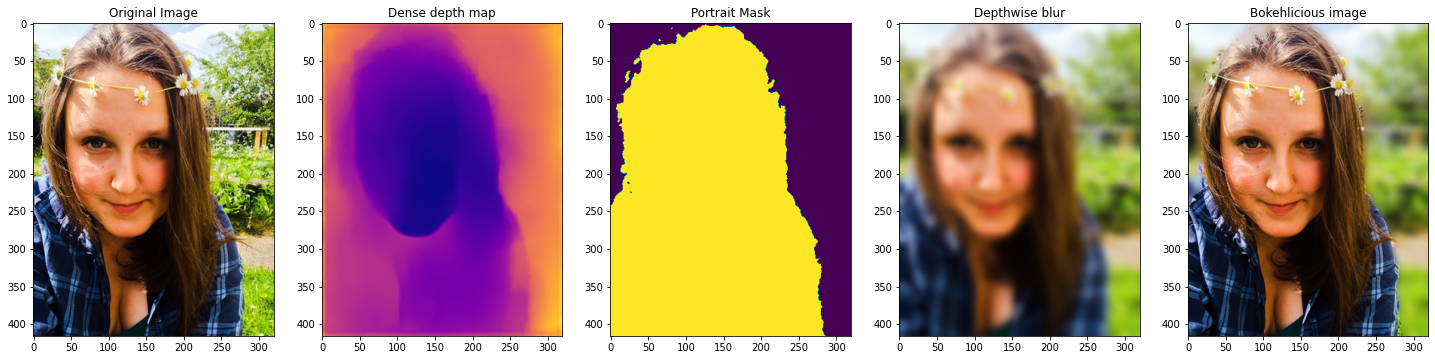

1/1 [==============================] - 2s 2s/step


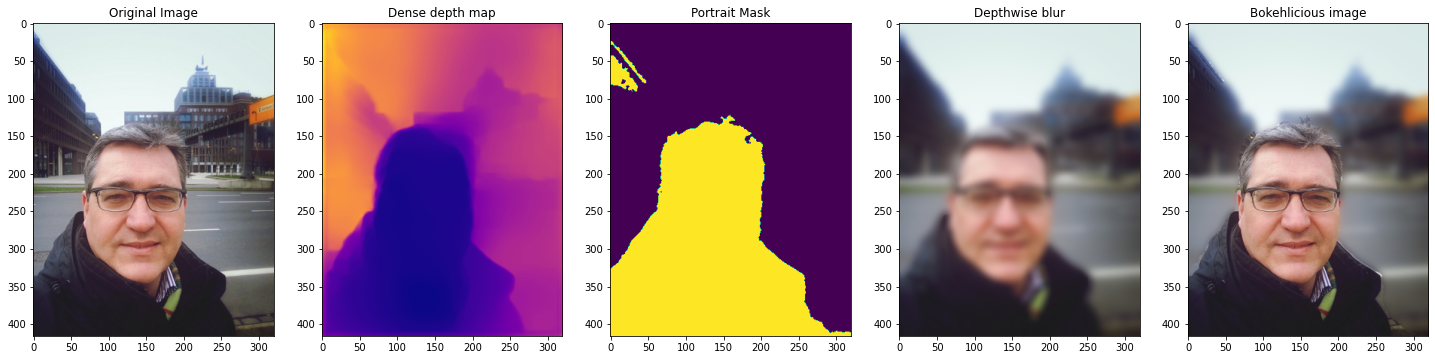

1/1 [==============================] - 2s 2s/step


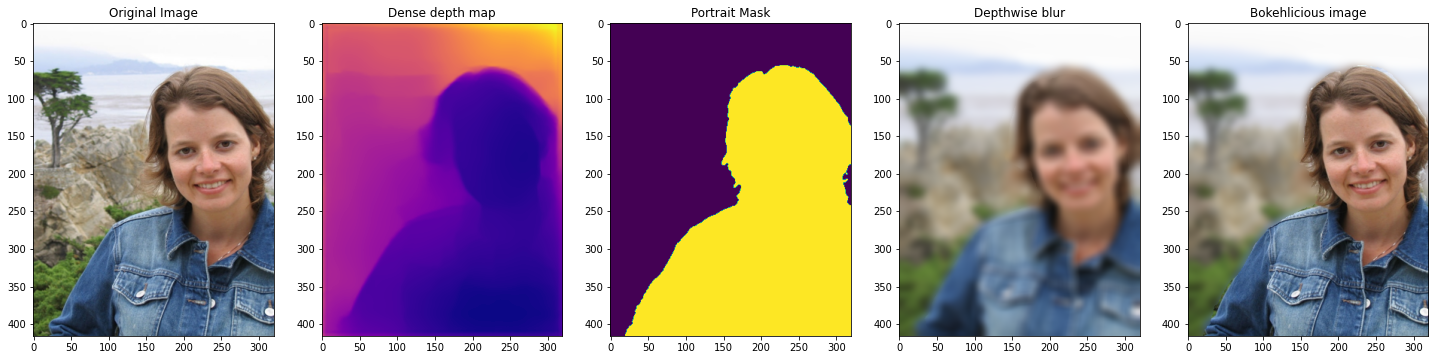

1/1 [==============================] - 2s 2s/step


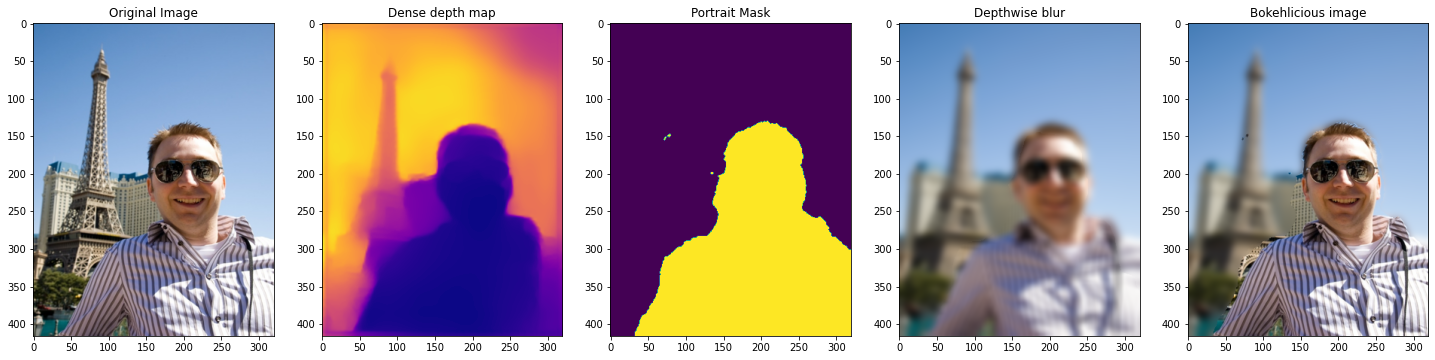

1/1 [==============================] - 2s 2s/step


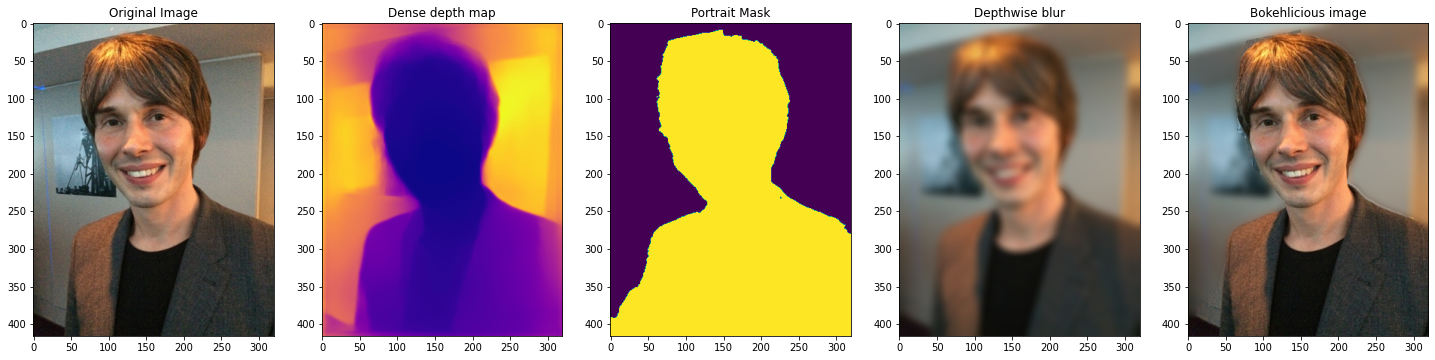

1/1 [==============================] - 2s 2s/step


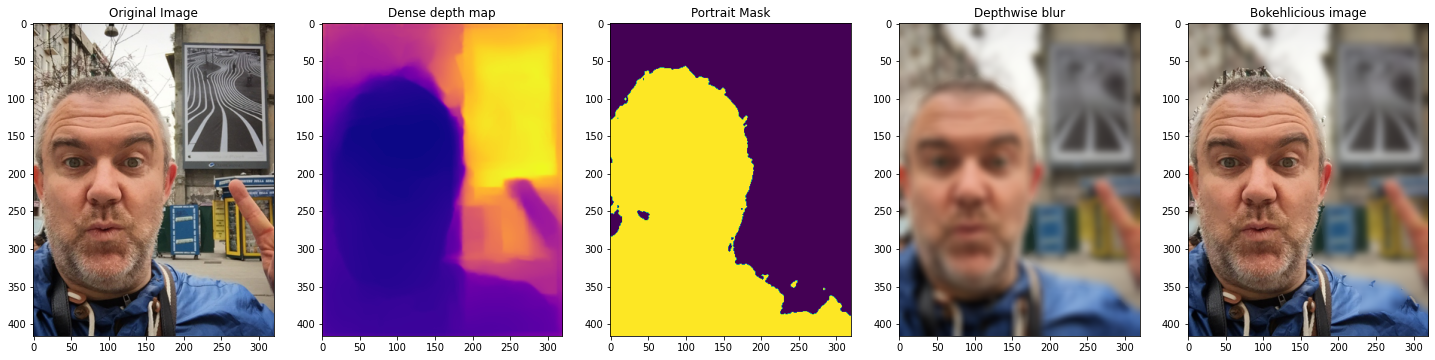

In [62]:
for image in sorted(os.listdir("test_images")):
    get_bokeh(f"test_images/{image}")